In [1]:
import os
import PyImbalReg as pir
import pandas as pd
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import resreg

In [2]:
df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_fuller_df.csv")

In [10]:
def label_func(faultD):
  if(faultD == 0): return 0
  elif(faultD < 500): return 1
  else: return 2

In [11]:
def bin_func(faultD):
  if(faultD == 0): return 0
  else: return (faultD//500 + 1)

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def reg_acc(md, data, test_labels):
  test_predictions = md.predict(data).flatten()
  r2 = r2_score(test_labels, test_predictions)
  rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))
  mae = mean_absolute_error(test_labels, test_predictions)

  print(f'r2 score: {r2}')
  print(f'rmse score: {rmse}')
  print(f'mae score: {mae}')
  # print(f'erro medio de: {rmse} segundos')

  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-100, 100], [-100, 100])

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score

def show_results(y_test, predictions):
  print('Accuracy score:', accuracy_score(y_test, predictions))
  # print('f1 score:', f1_score(y_test, predictions))
  # print('recall score:', recall_score(y_test, predictions))

  font = {'family' : 'serif', 'weight' : 'bold', 'size':18}
  plt.rc('font', **font)
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=None)
  disp.plot()
  plt.show()

In [14]:
df = df.sample(frac=1)
test_data = df[:(len(df)//5)]
train_data = df[(len(df)//5):]

test_data['bin'] = test_data.fault_duration.apply(bin_func)
test_data['fault'] = test_data['fault_duration'].apply(label_func)
test_data['is_fault'] = test_data.fault.apply(lambda x: 0 if x == 0 else 1)

X_test = test_data.drop(columns=['Unnamed: 0','NE ID','endTime', 'relation','fault_duration','bin','fault','is_fault']).values
y_test_fd = test_data.fault_duration.values
y_test = test_data.fault_duration.apply(label_func).values

train_data['fault'] = train_data['fault_duration'].apply(label_func)
train_data = train_data.dropna()
train_data = train_data.drop(columns=['Unnamed: 0','NE ID','endTime','relation'])
train_data['bin'] = train_data.fault_duration.apply(bin_func)
train_data['is_fault'] = train_data.fault.apply(lambda x: 0 if x == 0 else 1)

/tmp/ipykernel_55462/150606986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['bin'] = test_data.fault_duration.apply(bin_func)
/tmp/ipykernel_55462/150606986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['fault'] = test_data['fault_duration'].apply(label_func)
/tmp/ipykernel_55462/150606986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [15]:
y = train_data.fault.values
X = train_data.drop(columns=['fault','fault_duration','is_fault','bin']).values

faults = train_data[train_data['fault_duration'] > 0]
X_fault = faults.drop(columns=['fault','fault_duration']).values
y_fault = faults.is_fault.values

y_bin = [(lambda x: 0 if x==0 else 1 )(label)  for label in y]
y_test_bin = [(lambda x: 0 if x==0 else 1 )(label)  for label in y_test]

Accuracy score: 0.6071200365130077


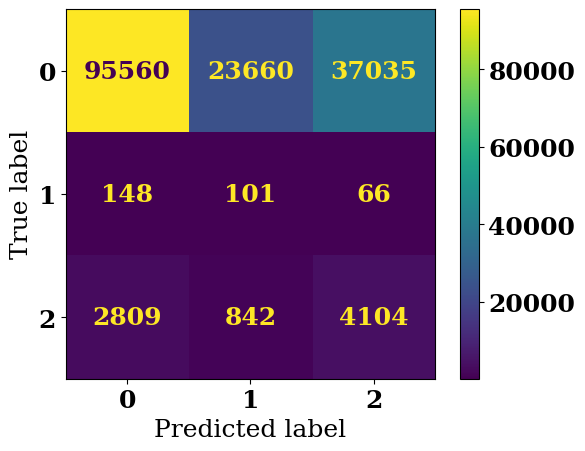

In [16]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier


bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X, y)
y_pred = bbc.predict(X_test)
show_results(y_test, y_pred)

Accuracy score: 0.9009036969420356


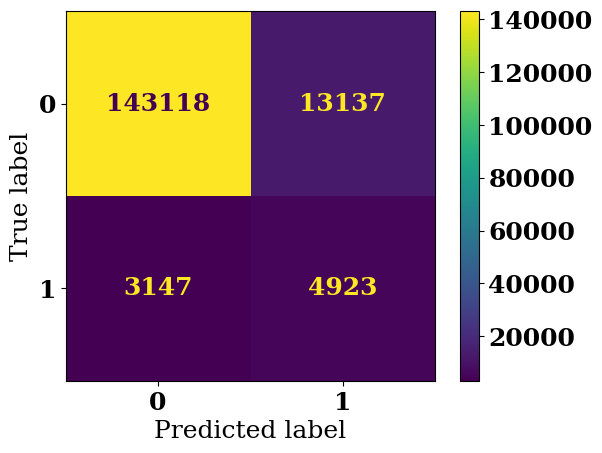

In [29]:

bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X, y_bin)
y_pred = bbc.predict(X_test)
show_results(y_test_bin, y_pred)

## balanced RF


Accuracy score: 0.36661493990567473


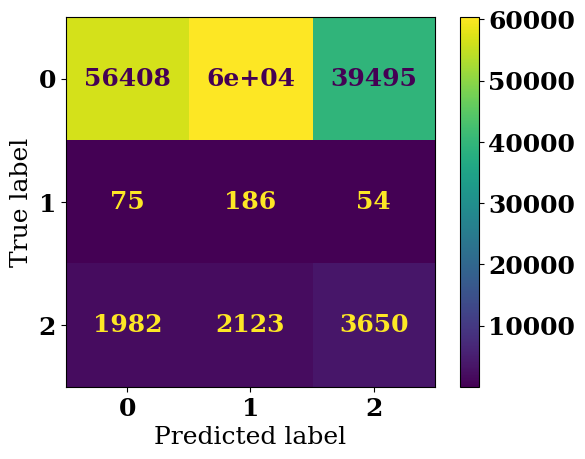

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier


rf = BalancedRandomForestClassifier(n_estimators=500,
    sampling_strategy="all", replacement=True, max_depth=5 ,random_state=0,
    bootstrap=False)

rf.fit(X, y)
y_pred = rf.predict(X_test)
show_results(y_test, y_pred)

Accuracy score: 0.9531720675490644


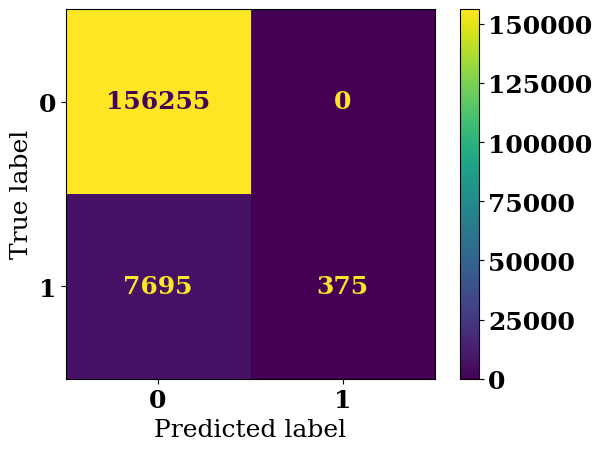

In [31]:
rf = BalancedRandomForestClassifier( max_depth=3, random_state=0,
    bootstrap=False)

rf.fit(X, y_bin)
y_pred = rf.predict(X_test)
show_results(y_test_bin, y_pred)